# Лабораторная работа №1: Реализация алгоритма SVM с различными ядрами

**Цель работы:**
Реализовать алгоритм опорных векторов (SVM) с нуля, исследовать различные ядерные функции и методы оптимизации.
## Задачи
1. Реализовать линейный SVM с помощью метода множителей Лагранжа и SMO алгоритма.
2. Реализовать ядерные функции:
   - Линейное:  $ K(x, y) = x \cdot y $
   - Полиномиальное:  $ K(x, y) = (x \cdot y + c)^d $
   - RBF (Гауссово):  $ K(x, y) = \exp(- \gamma  \|x - y \|^2) $
   - Сигмоидальное:  $ K(x, y) = \tanh( \alpha x \cdot y + c) $
3. Добавить soft-margin с параметром регуляризации $C$.
4. Исследовать влияние гиперпараметров:
   - $C$
   - $ \gamma $
   - степень $d$
5. Применить к задачам классификации и регрессии (SVR).
6. Сравнить с реализацией из scikit-learn.
7. Проанализировать опорные векторы и границу решений.
8. Оценить сложность для разных размеров данных.
## Источники данных
- Boston Housing (регрессия): этого датасета не существует
  ```
  from sklearn.datasets import load_boston
  data = load_boston()
  X_reg, y_reg = data.data, data.target
  ```
- Wine (классификация):
  ```
  from sklearn.datasets import load_wine
  data = load_wine()
  X_cls, y_cls = data.data, data.target
  ```
- Breast Cancer (классификация):
  ```
  from sklearn.datasets import load_breast_cancer
  data = load_breast_cancer()
  X_bc, y_bc = data.data, data.target
  ```
## Структура отчета
1. **Введение** — цели и описание алгоритма.
2. **Теория** — математическое обоснование SVM и ядер.
3. **Реализация** — код (NumPy).
4. **Эксперименты** — исследование гиперпараметров.
5. **Сравнение** — результаты scikit-learn vs ваша реализация.
6. **Выводы** — анализ и рекомендации.
,
## Критерии оценивания (15 баллов)
- Реализация SVM (линейный + ядра) — 6 баллов
- Проведение экспериментов и подбор гиперпараметров — 5 баллов
- Сравнительный анализ с scikit-learn (таблицы, графики) — 3 балла
- Качество отчета: структура, визуализации, комментарии в коде — 1 балл

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine, fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import scipy.spatial.distance as dist

### 1. Реализация линейного SVM (SMO)
Реализуйте методы:
- `fit(self, X, y)` — обучение
- `predict(self, X)` — предсказание

**Заготовка класса:**

Не понял как я должен это сделать без C, в статье реализация SMO под soft-margin, метод не предполагает отсутствие C. Qwen тоже не понимает, как он должен это сделать, и предлагает сделать C = 1e10

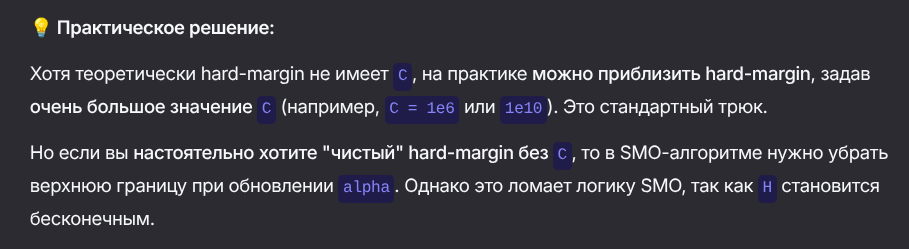

### 2. Ядерные функции
Реализовать функции
- `linear_kernel`
- `poly_kernel`
- `rbf_kernel`
- `sigmoid_kernel`

In [2]:
def linear_kernel(a, b):
    return np.dot(a, b.T)


def poly_kernel(a: np.ndarray, b: np.ndarray, degree: int=2,  coef_r: float=0.0):
        return (np.dot(a, b) + coef_r)**degree


def rbf_kernel(a, b, gamma):
    return np.exp(-gamma * dist.euclidean(a, b) ** 2)


def sigmoid_kernel(a, b, gamma, r):
    return np.tanh(gamma * np.dot(a, b) + r)

### 3. Soft-margin и параметры SVM
Добавьте поддержку параметра C и реализуйте SVR аналогично.

#### SVM

In [ ]:
class BinarySVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel=linear_kernel, tol=1e-3, max_iter=1000, **kernel_args):
        self.C = C
        self.kernel = kernel
        self.tol = tol
        self.max_iter = max_iter
        self.kernel_args = kernel_args
        
        self.b = 0
        self.alpha = None
        self.n_samples = 0
        self.X = None
        self.y = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None

    def _kernel_function(self, x1, x2):
        if callable(self.kernel):
            return self.kernel(x1, x2, **self.kernel_args)
        else:
            raise ValueError(f"Неподдерживаемое ядро: {self.kernel}")

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            for j in range(self.n_samples):
                self.K[i, j] = self._kernel_function(self.X[i], self.X[j])
        
        self.alpha = np.zeros(self.n_samples)

        iter_count = 0
        while iter_count < self.max_iter:
            num_changed_alphas = 0
            for i in range(self.n_samples):
                E_i = np.sum(self.alpha * self.y * self.K[:, i]) + self.b - self.y[i]
                if ((self.y[i] * E_i < -self.tol and self.alpha[i] < self.C) or
                    (self.y[i] * E_i > self.tol and self.alpha[i] > 0)):
                    
                    j = i
                    while j == i:
                        j = np.random.randint(0, self.n_samples)
                    
                    E_j = np.sum(self.alpha * self.y * self.K[:, j]) + self.b - self.y[j]
                    
                    alpha_i_old = self.alpha[i]
                    alpha_j_old = self.alpha[j]
                    
                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    
                    if L == H:
                        continue
                    
                    eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0:
                        continue
                    
                    self.alpha[j] -= self.y[j] * (E_i - E_j) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    
                    self.alpha[i] += self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])
                    
                    b1 = (self.b - E_i - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, i] 
                          - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K[i, j])
                    b2 = (self.b - E_j - self.y[j] * (self.alpha[j] - alpha_j_old) * self.K[j, j] 
                          - self.y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, j])
                    
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0
                    
                    num_changed_alphas += 1

            iter_count += 1

        sv_mask = self.alpha > 1e-5
        self.support_vectors = self.X[sv_mask]
        self.support_vector_labels = self.y[sv_mask]
        self.support_vector_alphas = self.alpha[sv_mask]
        
        self.is_fitted_ = True
        return self

    def decision_function(self, X):
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)
        
        kernel_matrix = np.zeros((X.shape[0], len(self.support_vectors)))
        for i in range(X.shape[0]):
            for j, sv in enumerate(self.support_vectors):
                kernel_matrix[i, j] = self._kernel_function(X[i], sv)
        
        decisions = np.dot(kernel_matrix, 
                        self.support_vector_alphas * self.support_vector_labels) + self.b
        return decisions

    def predict(self, X):
        decisions = self.decision_function(X)
        return np.where(decisions >= 0, 1, -1)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel=linear_kernel, tol=1e-3, max_iter=1000, **kernel_args):
        self.C = C
        self.kernel = kernel
        self.tol = tol
        self.max_iter = max_iter
        self.kernel_args = kernel_args

        self.classifiers = []
        self.classes_ = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        self.classes_ = unique_labels(y)
        
        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, -1)
            classifier = BinarySVM(
                C=self.C, 
                kernel=self.kernel, 
                tol=self.tol, 
                max_iter=self.max_iter,
                **self.kernel_args
            )
            classifier.fit(X, y_binary)
            self.classifiers.append(classifier)
        
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)
        
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        decision_scores = np.zeros((n_samples, n_classes))
        
        for i, classifier in enumerate(self.classifiers):
            decision_scores[:, i] = classifier.decision_function(X)
    
        predictions = self.classes_[np.argmax(decision_scores, axis=1)]
        return predictions
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

    def get_params(self, deep=True):
        params = super().get_params(deep=False)
        params.update({
            'C': self.C,
            'kernel': self.kernel,
            'tol': self.tol,
            'max_iter': self.max_iter
        })
        params.update(self.kernel_args)
        return params

    def set_params(self, **params):
        kernel_args_params = {}
        regular_params = {}
        for key, value in params.items():
            if key in ['C', 'kernel', 'tol', 'max_iter']:
                regular_params[key] = value
            else:
                kernel_args_params[key] = value
        for key, value in regular_params.items():
            setattr(self, key, value)
        if kernel_args_params:
            self.kernel_args.update(kernel_args_params)
        return self

#### SVR

In [10]:
from sklearn.metrics import r2_score

In [ ]:
class MySVR(BaseEstimator, RegressorMixin):
    def __init__(self, C=1.0, epsilon=0.1, kernel=linear_kernel, tol=1e-3, max_iter=1000, **kernel_args):
        self.C = C
        self.epsilon = epsilon
        self.kernel = kernel
        self.tol = tol
        self.max_iter = max_iter
        self.kernel_args = kernel_args

        self.b = 0
        self.alpha = None
        self.alpha_star = None
        self.n_samples = 0
        self.X = None
        self.y = None
        self.support_vectors = None
        self.support_vector_alphas = None
        self.support_vector_alpha_stars = None

    def _kernel_function(self, x1, x2):
        if callable(self.kernel):
            return self.kernel(x1, x2, **self.kernel_args)
        else:
            raise ValueError(f"Не поддерживаемое ядро: {self.kernel}")

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]

        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            for j in range(self.n_samples):
                self.K[i, j] = self._kernel_function(self.X[i], self.X[j])

        self.alpha = np.zeros(self.n_samples)
        self.alpha_star = np.zeros(self.n_samples)
        self.b = 0

        iter_count = 0
        while iter_count < self.max_iter:
            num_changed = 0
            for i in range(self.n_samples):
                f_i = np.sum((self.alpha - self.alpha_star) * self.K[:, i]) + self.b
                E_i = f_i - self.y[i]

                # alpha_i: если E_i > epsilon, то alpha_i < C
                # alpha_i*: если E_i < -epsilon, то alpha_i* < C
                if (E_i > self.epsilon and self.alpha[i] < self.C) or \
                   (E_i < -self.epsilon and self.alpha_star[i] < self.C) or \
                   (-self.epsilon <= E_i <= self.epsilon and (self.alpha[i] > 0 or self.alpha_star[i] > 0)):
                    
                    j = i
                    while j == i:
                        j = np.random.randint(0, self.n_samples)

                    f_j = np.sum((self.alpha - self.alpha_star) * self.K[:, j]) + self.b
                    E_j = f_j - self.y[j]

                    alpha_i_old = self.alpha[i]
                    alpha_i_star_old = self.alpha_star[i]
                    alpha_j_old = self.alpha[j]
                    alpha_j_star_old = self.alpha_star[j]

                    # L H
                    if self.y[i] == self.y[j]:
                        L = max(0, alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    else:
                        L = max(0, alpha_j_old - alpha_i_star_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_star_old)

                    if L == H:
                        continue

                    # eta
                    eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0:
                        continue

                    diff_i = alpha_i_old - alpha_i_star_old
                    diff_j = alpha_j_old - alpha_j_star_old

                    diff_j_new = diff_j - (E_i - E_j) / eta

                    total = diff_i + diff_j
                    diff_j_clipped = np.clip(diff_j_new, -self.C, self.C)
                    diff_i_new = total - diff_j_clipped
                    # либо alpha, либо alpha* = 0
                    if diff_i_new >= 0:
                        self.alpha[i] = diff_i_new
                        self.alpha_star[i] = 0
                    else:
                        self.alpha[i] = 0
                        self.alpha_star[i] = -diff_i_new

                    if diff_j_clipped >= 0:
                        self.alpha[j] = diff_j_clipped
                        self.alpha_star[j] = 0
                    else:
                        self.alpha[j] = 0
                        self.alpha_star[j] = -diff_j_clipped

                    if abs(self.alpha[j] - alpha_j_old) < 1e-5 and abs(self.alpha_star[j] - alpha_j_star_old) < 1e-5:
                        continue

                    # b
                    b1 = self.b - E_i - (self.alpha[i] - alpha_i_old) * self.K[i, i] \
                         - (self.alpha[j] - alpha_j_old) * self.K[i, j] \
                         + (self.alpha_star[i] - alpha_i_star_old) * self.K[i, i] \
                         + (self.alpha_star[j] - alpha_j_star_old) * self.K[i, j]

                    b2 = self.b - E_j - (self.alpha[i] - alpha_i_old) * self.K[i, j] \
                         - (self.alpha[j] - alpha_j_old) * self.K[j, j] \
                         + (self.alpha_star[i] - alpha_i_star_old) * self.K[i, j] \
                         + (self.alpha_star[j] - alpha_j_star_old) * self.K[j, j]

                    if 0 < self.alpha[i] < self.C or 0 < self.alpha_star[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C or 0 < self.alpha_star[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed += 1

            iter_count += 1
            if num_changed == 0:
                break

        sv_mask = (self.alpha > 1e-5) | (self.alpha_star > 1e-5)
        self.support_vectors = self.X[sv_mask]
        self.support_vector_alphas = self.alpha[sv_mask]
        self.support_vector_alpha_stars = self.alpha_star[sv_mask]

        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)

        kernel_matrix = np.zeros((X.shape[0], len(self.support_vectors)))
        for i in range(X.shape[0]):
            for j, sv in enumerate(self.support_vectors):
                kernel_matrix[i, j] = self._kernel_function(X[i], sv)

        predictions = np.dot(kernel_matrix, self.support_vector_alphas - self.support_vector_alpha_stars) + self.b
        return predictions

    def score(self, X, y):
        return r2_score(y, self.predict(X))

    def get_params(self, deep=True):
        params = {
            'C': self.C,
            'epsilon': self.epsilon,
            'kernel': self.kernel,
            'tol': self.tol,
            'max_iter': self.max_iter
        }
        params.update(self.kernel_args)
        return params

    def set_params(self, **params):
        kernel_args_params = {}
        regular_params = {}
        valid_params = ['C', 'epsilon', 'kernel', 'tol', 'max_iter']
        for key, value in params.items():
            if key in valid_params:
                regular_params[key] = value
            else:
                kernel_args_params[key] = value
        for key, value in regular_params.items():
            setattr(self, key, value)
        self.kernel_args.update(kernel_args_params)
        
        return self

### 4. Сравнение

#### Wine

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
data = load_wine()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### rbf

In [41]:
# sklearn
param_grid = {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Accuracy: 1.0


In [42]:
# my
param_grid = {
        'svm__kernel': [rbf_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': <function rbf_kernel at 0x7fcf478a8cc0>}
Accuracy: 0.9814814814814815


##### linear

In [6]:
# sklearn
param_grid = {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'svc__C': 1, 'svc__kernel': 'linear'}
Accuracy: 0.9814814814814815


In [9]:
# my
param_grid = {
        'svm__kernel': [linear_kernel],
        'svm__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'svm__C': 1, 'svm__kernel': <function linear_kernel at 0x7fc820b48720>}
Accuracy: 0.9814814814814815


##### poly

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
Accuracy: 1.0


In [ ]:
# my
param_grid = {
        'svm__kernel': [poly_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__degree': [2, 3, 4],
        'svm__coef_r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 10, 'coef_r': 0, 'degree': 2, 'kernel': <function poly_kernel at 0x7fcf478a8c20>}
Accuracy: 0.25925925925925924


##### sigmoid

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 0.1, 'coef0': 0, 'gamma': 0.01, 'kernel': 'sigmoid'}
Accuracy: 0.3888888888888889


In [ ]:
# my
param_grid = {
        'svm__kernel': [sigmoid_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1],
        'svm__r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(SVM(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 0.1, 'gamma': 0.01, 'kernel': <function sigmoid_kernel at 0x7fcf56519c60>, 'r': 0}
Accuracy: 0.35185185185185186


#### Breast Canser

In [10]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### rbf

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.6374269005847953


In [ ]:
# my
param_grid = {
        'svm__kernel': [rbf_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 0.1, 'gamma': 0.01, 'kernel': <function rbf_kernel at 0x7fcf478a8cc0>}
Accuracy: 0.631578947368421


##### linear

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 10, 'kernel': 'linear'}
Accuracy: 0.9707602339181286


In [ ]:
# my
param_grid = {
        'svm__kernel': [linear_kernel],
        'svm__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'C': 0.1, 'kernel': <function linear_kernel at 0x7fcf478a9120>}
Accuracy: 0.631578947368421


##### poly

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
# my
param_grid = {
        'svm__kernel': [poly_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__degree': [2, 3, 4],
        'svm__coef_r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

##### sigmoid

In [ ]:
# sklearn
param_grid = {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# my
param_grid = {
        'svm__kernel': [sigmoid_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1],
        'svm__r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(SVM(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

### SVR

#### California Housing

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
data = fetch_california_housing()
X, y = data.data[:500], data.target[:500]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### linear

In [8]:
param_grid_linear = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, n_jobs=-1)
grid_linear.fit(X_train, y_train)
print(grid_linear.best_params_)

y_pred_linear = grid_linear.predict(X_test)
print("Linear R² Score:", r2_score(y_test, y_pred_linear))
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_linear)))

{'svr__C': 0.1, 'svr__epsilon': 0.5}
Linear R² Score: 0.8030122316461256
Linear RMSE: 0.46607527901863455


In [15]:
param_grid_linear = {
    'svr__C': [0.1, 1],
    'svr__epsilon': [0.01, 0.1]
}

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=linear_kernel))
])

grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, n_jobs=-1)
grid_linear.fit(X_train, y_train)
print("Linear SVR - Лучшие параметры:", grid_linear.best_params_)

y_pred_linear = grid_linear.predict(X_test)
print("Linear R² Score:", r2_score(y_test, y_pred_linear))
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_linear)))

Linear SVR - Лучшие параметры: {'svr__C': 1, 'svr__epsilon': 0.01}
Linear R² Score: 0.5627290419356372
Linear RMSE: 0.6944032666156441


Exception ignored in: <function ResourceTracker.__del__ at 0x7f319b37c040>
Traceback (most recent call last):
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f3e20b80040>
Traceback (most recent call last):
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/flowersinvase/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exceptio

##### poly

In [56]:
param_grid_poly = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__degree': [2, 3, 4],
    'svr__coef0': [0, 0.5, 1, 2]
}

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

grid_poly = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, n_jobs=-1)
grid_poly.fit(X_train, y_train)
print("Polynomial SVR - Лучшие параметры:", grid_poly.best_params_)

y_pred_poly = grid_poly.predict(X_test)
print("Polynomial R² Score:", r2_score(y_test, y_pred_poly))
print("Polynomial RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))

Polynomial SVR - Лучшие параметры: {'svr__C': 0.1, 'svr__coef0': 1, 'svr__degree': 3, 'svr__epsilon': 0.1}
Polynomial R² Score: 0.8149046033345777
Polynomial RMSE: 0.37869527657460994


In [84]:
param_grid_poly = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__degree': [2, 3, 4],
    'svr__coef_r': [0, 1]
}

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=poly_kernel))
])

grid_poly = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, n_jobs=-1)
grid_poly.fit(X_train, y_train)
print("Polynomial SVR - Лучшие параметры:", grid_poly.best_params_)

y_pred_poly = grid_poly.predict(X_test)
print("Polynomial R² Score:", r2_score(y_test, y_pred_poly))
print("Polynomial RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))

TypeError: MySVR() takes no arguments

##### sigmoid

In [ ]:
param_grid_sigmoid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'svr__coef0': [0, 0.5, 1, 2]
}

pipeline_sigmoid = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='sigmoid'))
])

grid_sigmoid = GridSearchCV(pipeline_sigmoid, param_grid_sigmoid, cv=5, scoring='neg_mean_squared_error')
grid_sigmoid.fit(X_train, y_train)
print("Sigmoid SVR - Лучшие параметры:", grid_sigmoid.best_params_)

y_pred_sigmoid = grid_sigmoid.predict(X_test)
print("Sigmoid R² Score:", r2_score(y_test, y_pred_sigmoid))
print("Sigmoid RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sigmoid)))

##### rbf

In [ ]:
param_grid_rbf = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, scoring='neg_mean_squared_error')
grid_rbf.fit(X_train, y_train)
print("RBF SVR - Лучшие параметры:", grid_rbf.best_params_)

y_pred_rbf = grid_rbf.predict(X_test)
print("RBF R² Score:", r2_score(y_test, y_pred_rbf))
print("RBF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rbf)))

### 5. Выводы
   - Обсудите влияние гиперпараметров.
   - Сравните производительность и время обучения.
   - Дайте рекомендации по выбору ядер.